In [1]:
import csv
import pandas as pd
import numpy as np
import itertools as it
from random import random
from collections import namedtuple
from scipy.optimize import minimize
from scipy import stats
from sklearn.metrics import confusion_matrix
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pylab as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set()
sns.set_style('white')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
np.random.seed(1234)


## Importing the data and parsing the CSV.

- Each row represents a participant. 
- First 18 rows are patients. 
- Last 35 rows are controls. 
- Each column represents a trial. (Row number $x$ represents participant $x$ in each file.)

`CHOICES`: 
- $1\to$ stimulus A and 
- $2 \to$ stimulus B

`REWARDS`: 
- $1 \to$ reward and 
- $2 \to$ no reward

## Data structure after parsing

Lisr of namedtuples with two fields:

- `choices`: list of the choices for that person.

- `rewards`: list of the rewards for that person.



In [2]:
class Behaviour(object):
    Person = namedtuple('Person', 'choices, rewards, Vs')
    
    plot_params = {
            'label_size': 14,
            'title_size': 20,
            'subplot_size': 16,
            'blue': '#40599B',
            'red': '#D97575',
            'gold': '#d4af37',

    }
    
    def __init__(self, model):
        self.probs = {0: [0.50, 0.75], 1: [0.75, 0.25]}
        self.probs_switch = 30 
        
        self.model = model
        self.V0 = [[0, 0], [0,0], [0.3, 0.1]][model]
        self.V_update_fns = [self._m0_update_V, self._m1_update_V, self._m0_update_V][model]
        self.probability_fns = [self._m0_probability, self._m1_probability, self._m0_probability][model]
        
        self.param1_str = 'Epsilon'
        self.param2_str = ['Beta', 'Rho', 'Beta'][model]
        
        self.fit_starting_params = [(0.5, 5), (0.5, 5.5), (0.5, 5)][model]
        
    @staticmethod
    def explore_parameters(model=0, ppts=100, eps=(0,1), beta=(1, 15), 
                           eps_size=10, beta_size=15, plot=True, 
                           interactive=False, save=False):
        """ Parameter exploration. 
        Returns a 3D showing the number of rewards for different learning
        rates and negative energy values.
        :param: model (int, default 0): which model to use. 
        :param: ppts (int, default 100): number of participants.
        :param: eps (tuple, default (0, 1)): range of learning rate
        :param: beta (tuple, default (1, 15)): range of negative energy (models 1 and 3),
                                               or reward sensitivity (model 2).
        :param: eps_size (int, default 10): number of learning rates to try.
        :param: beta_size (int, default 15): number of negative energies / reward sensitivities
                                             to try.
        :param: plot (bool, default True)
        :param: interactive (bool, default False): whether to make the plot interactive.
                                                   only for jupyter notebooks, will probably
                                                   have to close after.
        :param: save (str, default False): name to save the figure.
        """
        # Get the parameters meshgrid
        params_eps, params_beta = Behaviour._get_params(eps, beta, 
                                                          eps_size, 
                                                          beta_size)
        # Initialise an empty rewards matrix
        rewards_out = np.zeros((eps_size, beta_size))
        
        for ind, _ in np.ndenumerate(rewards_out):
            params = [params_eps[ind], params_beta[ind]]
            # Simulate with the given parameters and calculate the rewards
            sim = Simulation(ppts, params, model=model)
            rewards_out[ind] = np.mean([np.sum(p.rewards) for p in sim.data])
        
        if plot:
            if interactive:
                # The interactive plot
                %matplotlib notebook
                fig = plt.figure()
                ax = fig.gca(projection='3d')
                plot = ax.plot_surface(params_beta, params_eps, 
                                       rewards_out, cmap='YlOrBr')
            else:
                # The regular plot
                fig = plt.figure(figsize=(20,7))
                ax1 = fig.add_subplot(1, 2, 1, projection='3d')
                plot1 = ax1.plot_surface(params_beta, params_eps, 
                                         rewards_out, cmap='YlOrBr')
                ax2 = fig.add_subplot(1, 2, 2, projection='3d')
                plot2 = ax2.plot_surface(params_eps, params_beta, 
                                         rewards_out, cmap='YlOrBr')    
                fig.colorbar(plot1, shrink=0.5)
                
                if model == 1:
                    eps_str, beta_str = 'learning rate', 'reward sensitivity'
                else:
                    eps_str, beta_str = 'learning rate', 'negative energy'
                fig.suptitle(f"""Total rewards for each {eps_str}, {beta_str} pair 
                for a simulation ran {ppts} times.""", 
                             fontsize=Behaviour.plot_params['title_size'])
                ax1.set_title('Angle 1', 
                              fontsize=Behaviour.plot_params['subplot_size'])
                ax2.set_title('Angle 2', 
                              fontsize=Behaviour.plot_params['subplot_size'])
                ax1.set_xlabel(f'{beta_str}', fontsize=Behaviour.plot_params['label_size'])
                ax1.set_ylabel(f'{eps_str}', fontsize=Behaviour.plot_params['label_size'])
                ax1.set_zlabel(f'Rewards', fontsize=Behaviour.plot_params['label_size'])
                
                ax2.set_ylabel(f'{beta_str}', fontsize=Behaviour.plot_params['label_size'])
                ax2.set_xlabel(f'{eps_str}', fontsize=Behaviour.plot_params['label_size'])
                ax2.set_zlabel(f'Rewards', fontsize=Behaviour.plot_params['label_size'])
                
                if save:
                    plt.savefig(f'figures/{save}.pdf', format='pdf')
                    
            max_indices = (np.int(np.argmax(rewards_out, axis=0)[0]), 
                          np.int(np.argmax(rewards_out, axis=1)[0]))
            print(f'Maximum reward corresponds to: ')
            print(f'  - {beta_str}: {params_beta[max_indices]}')
            print(f'  - {eps_str}: {params_eps[max_indices]}')
    
    # Helper function for explore_parameters
    @staticmethod
    def _get_params(eps, beta, eps_size, beta_size):
        """ Helper of explore_parameters.
        :param: eps (tuple): range of the first parameter
        :param: beta (tuple): range of the second parameter
        :param: eps_size (int): number of values for the first parameter.
        :param: beta_size (int): number of values for the second parameter.
        :returns: a transposed numpy meshgrid with the linear spaces of both parameters.
        """
        eps_space = np.linspace(eps[0], eps[1], num=eps_size)
        beta_space = np.linspace(beta[0], beta[1], num=beta_size)
        xx, yy = np.meshgrid(eps_space, beta_space)
        return xx.T, yy.T

    def neg_log_likelihood(self, params, person_ind):
        """ Compute the negative log likelihood for a participant given 
        a set of parameters.
        :param: params (tuple): parameters to use. 
        :param: person_ind (int): participant index.
        :returns: negative log likelihood
        """
        eps, beta = params[0], params[1]
        
        # The learning rate cannot be negative or bigger than 1 by defintion
        if eps < 0: eps = 0
        if eps > 1: eps = 1
        person, V = self.data[person_ind], self.V0[:]
        likelihoods = []
        for ind, choice in enumerate(person.choices):
            # Getting the indev of the choice for V
            choice_ind = choice - 1
            # Getiing the index of the other choice
            choice_ind_alt = int(choice_ind == 0)
            # Computing the probability of the choice with the appropiate model
            P_choice = self._probability(*[V, beta, choice_ind, choice_ind_alt])
            # Updating V with the appropiate model
            V = self._update_V(*[V, choice_ind, eps, beta, person.rewards[ind]])
            likelihoods.append(P_choice)
        return -np.sum(np.log(likelihoods))

    
    def _update_V(self, *args):
        """ Call the appropiate update_V function for the model.
        """
        return self.V_update_fns(*args)
    
    def _probability(self, *args):
        """ Call the appropiate probability function for the model
        """
        return self.probability_fns(*args)
    
    def _m0_probability(self, V, beta, choice_ind, choice_ind_alt):
        """ Probability for the model 0.
        :param: V (tuple): current reinforcement learning values
        :param: beta (float): negative energy
        :param: choice_ind (int): V index of the choice made
        :param: choice_ind_alt (int): V index of the other choice.
        :returns: probability
        """
        return (np.exp(beta * V[choice_ind]) / (np.exp(beta * V[choice_ind]) + 
                                                np.exp(beta * V[choice_ind_alt])))
    
    def _m1_probability(self, V, beta, choice_ind, choice_ind_alt):
        """ Probability for the model 1
        :param: V (tuple): current reinforcement learning values
        :param: beta (float): not used here.
        :param: choice_ind (int): V index of the choice made
        :param: choice_ind_alt (int): V index of the other choice.
        :returns: probability
        """
        return np.exp(V[choice_ind]) / (np.exp(V[choice_ind]) + np.exp(V[choice_ind_alt]))
        
    def _m0_update_V(self, V, choice_ind, eps, beta, reward):
        """ Update V for model 0
        :param: V (tuple): current reinforcement learning values
        :param: beta (float): not used here.
        :param: choice_ind (int): V index of the choice made
        :param: choice_ind_alt (int): V index of the other choice.
        :returns: updated reinforcement learning values
        """
        V[choice_ind] = V[choice_ind] + eps * (reward - V[choice_ind])
        return V
    
    def _m1_update_V(self, V, choice_ind, eps, rho, reward):
        """ Update V for model 1
        :param: V (tuple): current reinforcement learning values
        :param: rho (float): reward sensitivity.
        :param: choice_ind (int): V index of the choice made
        :param: choice_ind_alt (int): V index of the other choice.
        :returns: updated reinforcement learning values
        """
        V[choice_ind] = V[choice_ind] + eps * (rho * reward - V[choice_ind])
        return V
    
    def fit_model(self):
        """ Fit the model to data to find the best-fit parameters
        for each participant.
        :returns: eps_out (list): best-fit learning rate.
                  beta_out (list): best-fit neg-energy / reward-sens.
                  success_out (list): whether it succeeded for each ppt.
        """
        eps_out, beta_out, success_out = [], [], []
        starting_params = self.fit_starting_params[:]
        for ind, _ in enumerate(self.data):
            # Using scipy.minimize with BFGS option
            opt = minimize(self.neg_log_likelihood, starting_params, 
                           args=(ind), method='BFGS')
            eps_out.append(opt.x[0])
            beta_out.append(opt.x[1])
            success_out.append(opt.success)
        
        return eps_out, beta_out, success_out
    
    @staticmethod
    def parameter_recovery(ppts, model=0, num=53, plot=True, save=(False, False)):
        """ Perform parameter recovery.
        Simulate 53 sets of data with 53 random pairs of parameters, 
        then find the best-fit parameters and report the statistics.
        :params: ppts (int): number of participants for each simulation
        :params: model (int, default 0): which model to use
        :params: num (int, default 53): amount of data-sets to collect
        :params: plot (bool, default True)
        :param: save (tuple, default False): (name of plot 1, name of plot 2)
        """
        params_list = Behaviour._get_params_from_normal(num=num)
        eps_list = list(map(lambda x: x[0], params_list))
        beta_list = list(map(lambda x: x[1], params_list))

        sim = [Simulation(ppts, p, model=model) 
                for p in params_list]

        fit_params = [s.fit_model() for s in sim]
        
        eps_fit = list(map(lambda x: np.mean(x[0]), fit_params))
        beta_fit = list(map(lambda x: np.mean(x[1]), fit_params))
                        
        if plot:
            # Plot the starting parameters distribution
            Behaviour._plot_params_recovery(eps_list, beta_list, save[0])
            # Plot the parameter recovery
            Behaviour._plot_parameter_recovery(eps_list, beta_list, 
                                               eps_fit, beta_fit, save[1])

        r_eps = stats.pearsonr(eps_list, eps_fit)
        r_beta = stats.pearsonr(beta_list, beta_fit)
        
        print(f'{sim[0].param1_str}: {r_eps}')
        print(f'{sim[0].param2_str}: {r_beta}')
        
    @staticmethod
    def _get_params_from_normal(num=53, eps=(0.35, 0.01), beta=(5.5, 0.5)):
        """ Helper method for parameter_recovery.
        Get random parameters from a normal distribution given means and standard deviations.
        """
        return [[np.random.normal(eps[0], eps[1]), np.random.normal(beta[0], beta[1])] 
                for _ in range(num)]    
        
    @staticmethod
    def _plot_parameter_recovery(eps_list, beta_list, eps_fit, beta_fit, save=False):
        """ Helper function for parameter_recovery to illustrate the relation between the
        fit and the starting parameters.
        Calculates the lines of best fit
        """
        
        # Getting the best fit line for the first parameter
        eps_best_fit = np.polyfit(eps_list, eps_fit, 1)
        eps_best_fit_fn = np.poly1d(eps_best_fit)
        eps_best_fit_x = np.linspace(np.min(eps_list), np.max(eps_list), num=10)
        
        # Getting the best fit line for the second parameter
        beta_best_fit = np.polyfit(beta_list, beta_fit, 1)
        beta_best_fit_fn = np.poly1d(beta_best_fit)
        beta_best_fit_x = np.linspace(np.min(beta_list), np.max(beta_list), num=10)
        
        fig, axs = plt.subplots(1, 2, figsize=(13, 4))
        axs[0].scatter(eps_list, eps_fit, color=Behaviour.plot_params['red'])
        axs[0].plot(eps_best_fit_x, eps_best_fit_fn(eps_best_fit_x), 
                    color=Behaviour.plot_params['gold'])
        axs[1].scatter(beta_list, beta_fit, color=Behaviour.plot_params['blue'])
        axs[1].plot(beta_best_fit_x, beta_best_fit_fn(beta_best_fit_x), 
                    color=Behaviour.plot_params['gold'])
        axs[0].set_yticks(np.linspace(0.2, 0.6, num=10))
        fig.suptitle('Relationship between starting parameters and best fit parameters', 
                     fontsize=Behaviour.plot_params['title_size'])
        axs[0].set_xlabel('Starting learning rate', fontsize=Behaviour.plot_params['label_size'])
        axs[0].set_ylabel('Best-fit learning rate', fontsize=Behaviour.plot_params['label_size'])
        axs[1].set_xlabel('Starting negative energy', fontsize=Behaviour.plot_params['label_size'])
        axs[1].set_ylabel('Best-fit negative energy', fontsize=Behaviour.plot_params['label_size'])
        if save:
            plt.savefig(f'figures/{save}.pdf', format='pdf')
                
    @staticmethod
    def _plot_params_recovery(eps_list, beta_list, save=False):
        """ Helper function for parameter_recovery to illustrate the distribution of the starting parameters.
        """
        num = range(len(eps_list))
        fig, axs = plt.subplots(1, 2, figsize=(13, 4), sharey=True)
        axs[0].hist(eps_list, color=Behaviour.plot_params['red'], bins=15)
        axs[1].hist(beta_list, color=Behaviour.plot_params['blue'], bins=15)
        fig.suptitle('Parameters randonmly sampled from a normal distribution', 
                     fontsize=Behaviour.plot_params['title_size'])
        axs[0].set_xlabel('Learning rate (epsilon)', fontsize=Behaviour.plot_params['label_size'])
        axs[0].set_ylabel('Count', fontsize=Behaviour.plot_params['label_size'])
        axs[1].set_xlabel('Negative energy (beta)', fontsize=Behaviour.plot_params['label_size'])
        
        if save:
            plt.savefig(f'figures/{save}.pdf', format='pdf')
    
    @staticmethod
    def model_comparison():
        data = [RealData(model=n) for n in range(3)]
        AICs, BICs = [], []
        
        for m in data:
            eps_out, beta_out, success = m.fit_model()
            AIC, BIC = 0, 0
            
            for ind, ppt in enumerate(m.data):
                params = [eps_out[ind], beta_out[ind]]
                NLL = m.neg_log_likelihood(params, ind)
                AIC += Behaviour.get_AIC(NLL)
                BIC += Behaviour.get_BIC(NLL, len(ppt.choices))
                
            AICs.append(AIC)
            BICs.append(BIC)
        
        return AICs, BICs
    
    @staticmethod
    def get_AIC(NLL, p=2):
        return 2 * NLL + 2 * p
    
    @staticmethod
    def get_BIC(NLL, n, p=2):
        return 2 * NLL + p * np.log(n)
    
    @staticmethod
    def model_recovery(ppts=100, trials=100):
        starting= [((0.35, 0.01), (5.5, 0.5)), 
                   ((0.30, 0.01), (6.0, 0.5)), 
                   ((0.35, 0.01), (5.5, 0.5))]
        
        for _ in trials:
            
            AICs, BICs = [], []

            for model in range(3):
                params = Behaviour.get_params_from_normal(num=1, eps=starting[model][0], 
                                                          beta=starting[model][1])
                m = Simulation(100, params)
                eps_out, beta_out, success = m.fit_model()
                AIC, BIC = 0, 0
            
                for ind, ppt in enumerate(m.data):
                    fit_params = [eps_out[ind], beta_out[ind]]
                    NLL = m.neg_log_likelihood(fit_params, ind)
                    AIC += Behaviour.get_AIC(NLL)
                    BIC += Behaviour.get_BIC(NLL, len(ppt.choices))
                
    

In [3]:
class RealData(Behaviour):
    """ For real data, from a CSV
    """
    def __init__(self, model=0, choices_file='choices.csv', 
                 rewards_file='rewards.csv', 
                 path='data/'):
        super(RealData, self).__init__(model)
        self.data = RealData._parse_csv()
        self.threshold = 18
        self.ppts_num = len(self.data)
        
    @staticmethod    
    def _parse_csv(choices_file='choices.csv', 
                   rewards_file='rewards.csv', 
                   path='data/'):
        """
        Parse the CSV. 
        - Each row index is a participant number. 
        - Each row is a list of trials.
        :param: choices_file (str): default choices.csv
        :param: rewards_file (str): default rewards.csv
        :param: path (str): path to files
        :returns: list of Person namedtuples
        """
        out = []
        # Opening choices file
        with open(path + choices_file, newline='') as csv_choices:
            reader_choices = csv.reader(csv_choices)
            # Opening rewards file
            with open(path + rewards_file, newline='') as csv_rewards:
                reader_rewards = list(csv.reader(csv_rewards))
                
                # For each (choice, reward) pair
                for n, row in enumerate(reader_choices):
                    # Convert to int
                    cs = list(map(int, row))
                    rs = list(map(int, reader_rewards[n]))
                    # Inialise a new Person
                    data = Behaviour.Person(choices=cs, rewards=rs, Vs=[])
                    out.append(data)
        return out
    
    def explore(self, stats=True, plot=True, save=False):
        """ Explore the real data. 
        :param: stats (bool, default True): whether to print the statistics (mean, std, range)
        :param: plot (bool, default True): whether to plot the rewards and choices
        :param: save (str, default False): whether to save the plot
        """
        rewards_out = []
        choices_out = []
        for person in self.data:
            # Number of times a person chooses A
            c = np.sum([c == 1 for c in person.choices])
            choices_out.append(c)
            # Total rewards
            r = np.sum(person.rewards)
            rewards_out.append(r)
    
        if stats:
            total = len(self.data[0].choices)
            print('Number of times stimulus A was chosen:')
            print(f'    Mean: {np.mean(choices_out)}, out of {total}')
            print(f'    Std: {np.std(choices_out)}')
            print(f'    Max: {np.max(choices_out)}')
            print(f'    Min: {np.min(choices_out)}')
            print('Rewards:')
            print(f'    Mean: {np.mean(rewards_out)} out of {total}')
            print(f'    Std: {np.std(rewards_out)}')
            print(f'    Max: {np.max(rewards_out)}')
            print(f'    Min: {np.min(rewards_out)}')
            
        if plot:
            xs = range(len(rewards_out))
            width = np.float32(1.0 / 3)
            fig = plt.figure(figsize=(20,5))
            plt.bar(xs - width, choices_out, width, color=Behaviour.plot_params['blue'])
            plt.bar(xs, rewards_out, width, color=Behaviour.plot_params['red'])
            plt.xticks(xs, xs, fontsize=13)
            plt.legend(['Number of times participant chose $A$', 'Total rewards'])
            plt.xlabel('Participant number', fontsize=Behaviour.plot_params['label_size'])
            plt.ylabel('Count', fontsize=Behaviour.plot_params['label_size'])
            plt.title('Person distribution', fontsize=Behaviour.plot_params['title_size'])
            if save:
                plt.savefig(f'figures/{save}.pdf', format='pdf')

    def model_fit_stats(self, plot=True, filter_params=False, save=False, title=''):
        """ Print the results of fitting the model to the real data.
        :param: plot (bool, default True)
        :param: filter_params (bool, default False): whether to filter the parameters not in the normal range
        :param: save (str, default False): name of the figure
        """
        eps_out, beta_out, success_out = self.fit_model()
        
        if filter_params:
            eps_out, beta_out = self._filter_fit_params(eps_out, beta_out)
            
        if plot:
            self._plot_fit_model(eps_out, beta_out, save=save, title=title)
        
        eps_out = list(filter(lambda x: x > 0, eps_out))
        beta_out = list(filter(lambda x: x > 0, beta_out))
                
        eps_healthy = eps_out[self.threshold:]
        eps_mdd = eps_out[:self.threshold]
        beta_healthy = beta_out[self.threshold:]
        beta_mdd = beta_out[:self.threshold]
            
        pearson = stats.pearsonr(eps_out, beta_out)
        pearson_healthy = stats.pearsonr(eps_healthy, beta_healthy)
        pearson_mdd = stats.pearsonr(eps_mdd, beta_mdd)
        
        t_eps = stats.ttest_ind(eps_mdd, eps_healthy)
        t_beta = stats.ttest_ind(beta_mdd, beta_healthy)
        
        self._print_model_fit_stats(eps_out, beta_out,
                                    eps_healthy, eps_mdd, 
                                    beta_healthy, beta_mdd, 
                                    pearson, pearson_mdd, 
                                    pearson_healthy, t_eps, 
                                    t_beta)

        
    def _filter_fit_params(self, eps_list, beta_list):
        """ Helper function for model_fit_stats to filter the parameters
        that do not fall within normal range.
        :param: eps_list (list): list of learning rates
        :param: beta-List (list): list of negative energies / reward sensitivities
        :returns: (filtered_eps, filtered_beta)
        """
        
        def _helper_filter(eps, beta):
            """ Helper function for filter_fit_params that returns
            the parameters if they lie within the normal range, and
            (0,0) otherwise.
            """
            if eps < 1 and eps > 0 and beta > 1 and beta < 15:
                return eps, beta
            else:
                return 0,0
        
        return list(zip(*[(_helper_filter(eps, beta))
                          for eps, beta in zip(eps_list, beta_list)]))
        
    def _print_model_fit_stats(self, eps_out, beta_out,
                              eps_healthy, eps_mdd, 
                              beta_healthy, beta_mdd, 
                              pearson, pearson_mdd, pearson_healthy, 
                              t_eps, t_beta):
        """ Helper function to print the model fit statistics.
        """
        
        print(f'Mean {self.param1_str}: {np.mean(eps_out)}')
        print(f'Std of {self.param1_str}: {np.std(eps_out)}')
        print(f'Mean {self.param2_str}: {np.mean(beta_out)}')
        print(f'Std of {self.param2_str}: {np.std(beta_out)}')
        
        print('\nPearson correlations')
        print(f'  - Overall: {pearson}')
        print(f'  - MDD: {pearson_mdd}')
        print(f'  - Healthy: {pearson_healthy}')
        
        print('\nT-test')
        print(f'{self.param1_str}')
        print(f'  - T statistic: {t_eps.statistic}')
        print(f'  - p value: {t_eps.pvalue}')
        
        print(f'{self.param2_str}')
        print(f'  - T statistic: {t_beta.statistic}')
        print(f'  - p value: {t_beta.pvalue}')
            
            
    def _plot_fit_model(self, eps_out, beta_out, bounds=[(0,1), (0, 20)], save=False, title=''):
        """ Helper function to plot the model-fit.
        """
        eps_healthy = eps_out[self.threshold:]
        eps_mdd = eps_out[:self.threshold]
        beta_healthy = beta_out[self.threshold:]
        beta_mdd = beta_out[:self.threshold]
        
        ppts = range(len(eps_healthy) + len(eps_mdd))
        fig, axs = plt.subplots(2, figsize=(16,8), sharex=True)
        fig.suptitle('Parameter estimations for MDD and healthy participants' + ' ' + title, 
                         fontsize=Behaviour.plot_params['title_size'])
        
        axs[0].plot(ppts[:self.threshold], eps_mdd, 
                    color=Behaviour.plot_params['red'], label='MDD')
        axs[0].scatter(ppts[:self.threshold], eps_mdd, 
                       color=Behaviour.plot_params['red'])
        axs[0].plot(ppts[self.threshold:], eps_healthy, 
                    color=Behaviour.plot_params['blue'], label='Healthy')
        axs[0].scatter(ppts[self.threshold:], eps_healthy, 
                       color=Behaviour.plot_params['blue'])
        axs[1].plot(ppts[:self.threshold], beta_mdd, 
                    color=Behaviour.plot_params['red'], label='MDD')
        axs[1].scatter(ppts[:self.threshold], beta_mdd, 
                     color=Behaviour.plot_params['red'])
        axs[1].plot(ppts[self.threshold:], beta_healthy, 
                    color=Behaviour.plot_params['blue'], label='Healthy')
        axs[1].scatter(ppts[self.threshold:], beta_healthy, 
                       color=Behaviour.plot_params['blue'])
        axs[0].grid()
        axs[1].grid()
        axs[0].set_xticks(ppts)
        axs[0].set_yticks(np.linspace(bounds[0][0], bounds[0][1], num=11))
        axs[1].set_yticks(np.linspace(bounds[1][0], bounds[1][1], num=11))
        axs[1].set_xlabel('Participant number', fontsize=Behaviour.plot_params['label_size'])
        axs[0].set_ylabel(f'{self.param1_str}', fontsize=Behaviour.plot_params['label_size'])
        axs[1].set_ylabel(f'{self.param2_str}', fontsize=Behaviour.plot_params['label_size'])
            
        handles, labels = axs[1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right')
        
        if save:
            plt.savefig(f'figures/{save}.pdf', format='pdf')
        

In [4]:
        
class Simulation(Behaviour):
    """ For simulated data.
    """
    def __init__(self, ppts_num, params, model=0, trials=240):
        super(Simulation, self).__init__(model)
        self.params = params
        self.ppts_num = ppts_num
        self.data = self.simulate(ppts_num, params, trials)
    
    def _switch_probs(self, trial, probs_key):
        if trial % self.probs_switch == 0:
            return probs_key == 0
        else:
            return probs_key
    
    def simulate(self, ppts, params, trials):
        """ Simulate the choices and rewards for "ppts" participants 
        with "trials" amount of choices.
        :param: ppts (int): number of participants
        :param: params (tuple): learning rate and negative energy if using models 1 or 3, 
                                otherwise learning rate and reward sensitivity.
        :param: trials: number of times to simulate.
        :returns: the simulated data (list of Person)
        """
        # Initialising variables and an empty dataset
        eps, beta = params[0], params[1]
        # Setting the initial probability key to 0
        probs_key = 0
        # Initialising an empty output list
        data = []
        for _ in range(ppts):
            V = self.V0
            choices, rewards, Vs = [], [], []
            for t in range(trials):
                # Simulate this trial
                choice, reward, V = self._trial(eps, beta, V, 
                                                self.probs[probs_key])
                # Switch the probabilities if needed
                probs_key =  self._switch_probs(t+1, probs_key)
                choices.append(choice)
                rewards.append(reward)
                Vs.append(V[:])
                
            data.append(Behaviour.Person(choices=choices, 
                                             rewards=rewards, 
                                             Vs=Vs))
        return data
            
       
    def _trial(self, eps, beta, V, probs):
        """ Perform a trial
        :param: eps (float): learning rate
        :param: beta (float): negative energy (models 1 and 3) or 
                              reward sensitivity (model 2)
        :param: V (tuple): the reinforcement learning values
        :param: probs (tuple): probability of reward given both choices.
        :returns: the new choice, reward and V.
        """
        prob_A = np.exp(beta * V[0]) / (np.exp(beta * V[0]) + np.exp(beta * V[1]))
        # - If P(A) > than a random number between 0 and 1, the choice is
        #   1 + 0 -> A
        # - If P(A) < than a random number between 0 and 1, the choice is
        #   1 + 1 -> B
        choice = 1 + (prob_A < random())
        choice_ind = choice - 1
        # Reward using the probability of reward given choice A or B
        reward = int(probs[choice_ind] > random())
        # Update the value according to the model used.
        V = self._update_V(V, choice_ind, eps, beta, reward)
        return choice, reward, V
    
    def explore(self, plot=True, save=False):
        """ Explore the simulated data.
        Plots the evolution of the mean values of V(A), V(B) and V(A) - V(B). 
        :params: plot (bool, default True): whether to plot or not
        :param: save (str, default False): name of the figure.
        """
        # Initialise empty evolutions.
        A_evol, B_evol, AB_evol = [], [], []
        indices = range(1, len(self.data[0].Vs) + 1, 1)
        for V in list(map(lambda x: x-1, indices)):
            # Get the mean V(A) evolution
            A_evol.append(np.mean([ppt.Vs[V][0] for ppt in self.data]))
            # Get the mean V(B) evolution
            B_evol.append(np.mean([ppt.Vs[V][1] for ppt in self.data]))
            # Get the mean V(A) - V(B) evolution
            AB_evol.append(np.mean([ppt.Vs[V][0] - ppt.Vs[V][1] 
                                    for ppt in self.data]))
        
        if plot:
            fig = plt.figure(figsize=(20, 4), 
                             constrained_layout=True)
            # Configuring grid and subplots
            gs = fig.add_gridspec(2, 2)
            ax1 = fig.add_subplot(gs[0, 0])
            ax1.set_title('Evolution of the value of stimulus A ($V_A$)', 
                          fontsize=Behaviour.plot_params['subplot_size'] + 4)
            ax2 = fig.add_subplot(gs[1, 0])
            ax2.set_title('Evolution of the value of stimulus B ($V_B$)', 
                          fontsize=Behaviour.plot_params['subplot_size'] + 4)
            ax3 = fig.add_subplot(gs[:, 1])
            ax3.set_title('Evoluion of the difference of stimuli values ($V_A - V_B$)', 
                          fontsize=Behaviour.plot_params['subplot_size'] + 4)
            # Setting the figure title
            fig.suptitle(f'Evolution of the average stiumli values for a simulation ran {len(self.data)} times', 
                         fontsize=Behaviour.plot_params['title_size'] + 4)
            # Making the plots
            ax1.plot(indices, A_evol, color=Behaviour.plot_params['blue'])
            ax2.plot(indices, B_evol, color=Behaviour.plot_params['blue'])
            ax3.plot(indices, AB_evol, color=Behaviour.plot_params['red'])
            # Setting the labels
            ax1.set_xlabel('Trial number', 
                           fontsize=Behaviour.plot_params['label_size'] + 4)
            ax2.set_xlabel('Trial number', 
                           fontsize=Behaviour.plot_params['label_size'] + 4)
            ax3.set_xlabel('Trial number', 
                           fontsize=Behaviour.plot_params['label_size'] + 4)
            ax1.set_ylabel('$V_A$', fontsize=Behaviour.plot_params['label_size'] + 4)
            ax2.set_ylabel('$V_B$', fontsize=Behaviour.plot_params['label_size'] + 4)
            ax3.set_ylabel('$V_A - V_B$', fontsize=Behaviour.plot_params['label_size'] + 4)
            
            p_changes = list(range(30, 240, 30))
            # Setting the vertical lines
            for ax in [ax1, ax2, ax3]:
                for x_cord in p_changes:
                    ax.axvline(x=x_cord, color=Behaviour.plot_params['gold'], linestyle='--')
            # Setting the ticks
            yticks_12 = np.linspace(0, 1, num=3)
            ax1.set_yticks(yticks_12)
            ax1.set_xticks(p_changes)
            ax2.set_xticks(p_changes)
            ax2.set_yticks(yticks_12),
            ax3.set_xticks(p_changes)
            ax3.set_yticks(np.linspace(-1, 1, num=6))
            
            if save:
                plt.savefig(f'figures/{save}.pdf', format='pdf')
                
            average_rewards = np.mean([np.sum(ppt.rewards) for ppt in self.data])
            print(f'Average number of rewards: {average_rewards}')
    
    

### Real data exploration

To explore the real data the number of times stimulus $A$ was chosen and the number of rewards for each participant were examined. For each of these, the 

- mean,
- standard deviation,
- minimum value and
- maximum value

are printed. 


[0, 0]
(0.5, 5)
Number of times stimulus A was chosen:
    Mean: 141.0, out of 240
    Std: 20.309863762165808
    Max: 200
    Min: 108
Rewards:
    Mean: 153.52830188679246 out of 240
    Std: 6.634966760192877
    Max: 166
    Min: 134


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


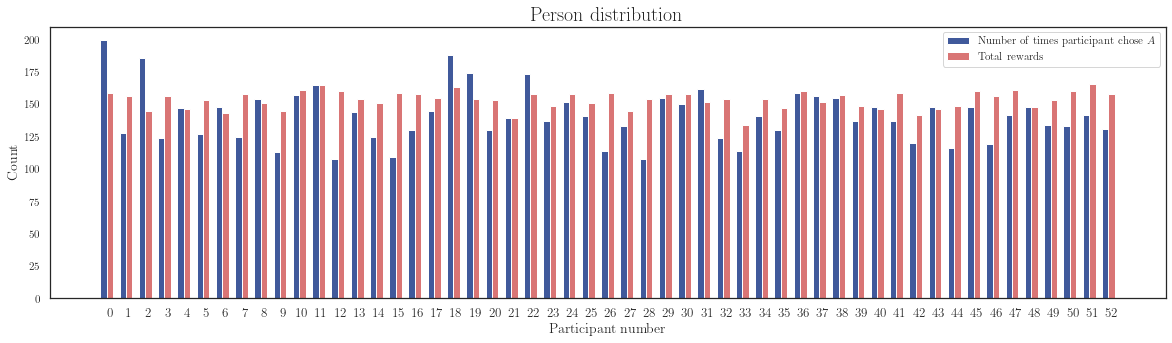

In [5]:
real_data = RealData()
real_data.explore(save='2.1')

### Simulated data exploration

To explore the simualted data 240 choices were simulated 100 times (representing 100 participants) with starting parameters $(\epsilon=0.35, \beta=5.5)$.

The plots show

- the mean evolution of $V^A$, 
- the mean evolution of $V^B$, and
- the mean evolution of $V^A - V^B$.

[0, 0]
(0.5, 5)
Average number of rewards: 153.35


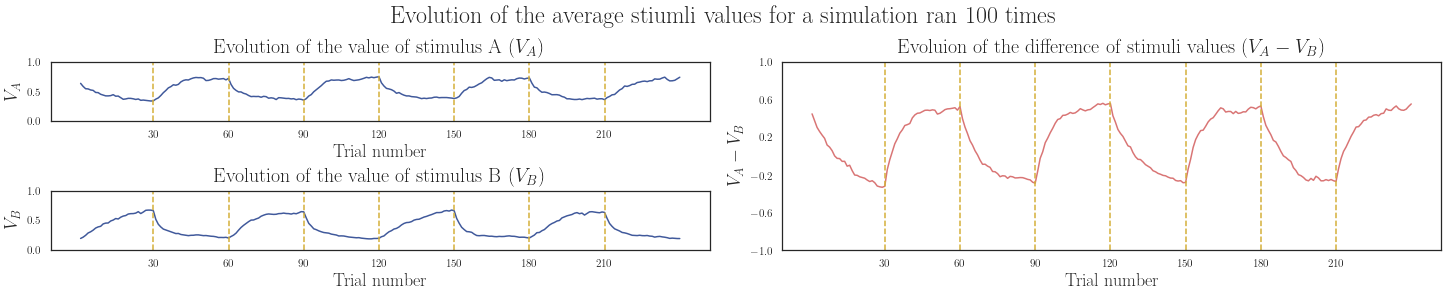

In [6]:
simulated_data = Simulation(100, (0.35, 5.5))
simulated_data.explore(save='2.2')

### Parameter exploration

For the parameter exploration, the values for the parameters were assigned:

- $\epsilon_{\text{values}}$: linear space of 10 elements with range $[0, 1]$, 
- $\beta_{\text{values}}$: linear space of 15 elements with range $[1, 15]$.

Then, a simulation with 100 participants was performed for each pair of parameter values. The plot represents the amount of reward for each pair.

Maximum reward corresponds to: 
  - negative energy: 12.0
  - learning rate: 0.7777777777777777


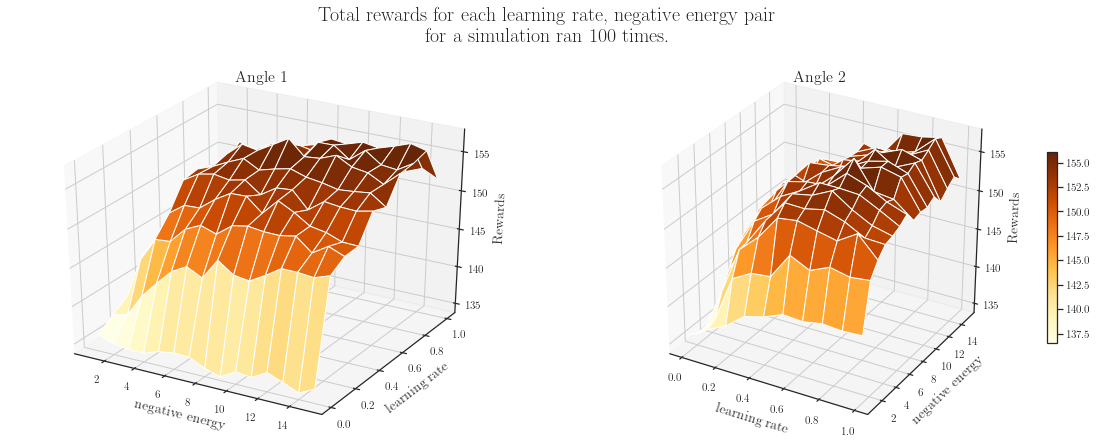

In [51]:
Behaviour.explore_parameters()

### Testing the Negative Log Likelihood function

To test the negative log likelihood the first patient should have a value of around 52 when $\epsilon = 0.4$ and $\beta = 6$. 

The NLL of the second patient was also reported

In [53]:
params = (0.4, 6)
print(f'Test for the first participant: {int(real_data.neg_log_likelihood(params, 0)) == 52}')

print(f'NNL for second participant: {real_data.neg_log_likelihood(params, 1)}')

Test for the first participant: True
NNL for second participant: 63.83424612963225


## Fitting the model to the real data

The model was fit to the real data using $\epsilon = 0.5$ and $\beta = 5$ for the starting parameters. Reporting:

- mean and standard deviation of the learning rate (LR)
- mean and standard deviation of the negative energy (NE)
- Overall pearson correlations between LR and NE with p-value.
- Healthy pearson correlations between LR and NE with p-value.
- MDD pearson correlations between LR and NE with p-value.
- 2-sample T-statistic and p-value of LR-healthy and LR-MDD 
- 2-sample T-statistic and p-value of NE-healthy and NE-MDD 

The plot shows the parameters estimated for each participant.

Mean Epsilon: 0.36417977113394273
Std of Epsilon: 0.12379305404434741
Mean Beta: 5.833741251163507
Std of Beta: 1.2533106045022249

Pearson correlations
  - Overall: (-0.22368507564054005, 0.11091876617802127)
  - MDD: (-0.29707701832944255, 0.231240367512403)
  - Healthy: (-0.13096284044264161, 0.46035445445594086)

T-test
Epsilon
  - T statistic: 1.3254161009076024
  - p value: 0.19105773439881502
Beta
  - T statistic: -0.663539868779145
  - p value: 0.5100328498878492


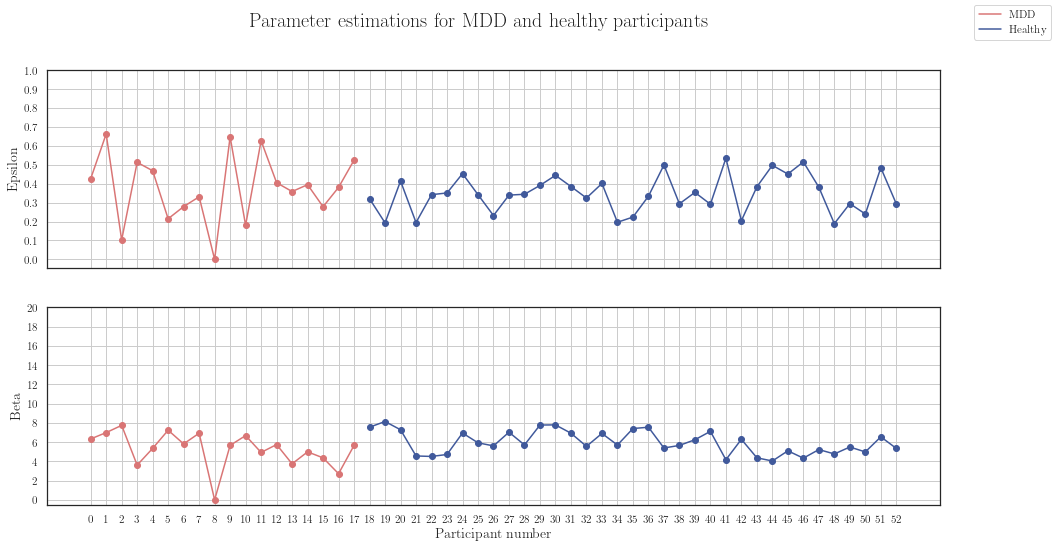

In [61]:
real_data.model_fit_stats(filter_params=True, save='2.4')

### Parameter recovery

For the parameter recovery 53 pairs of parameters were obtained randomly from a normal distribution. Then, 53 `Simulation` instances of 10 participants each were created. For each instance, the average best-fit parameters were computed. The pearson correlation between the starting and the best-fit parameters is reported for both the LR and the NE.

The first plot shows the distributions of the starting LE and NE.

The second plot shows the relation between the starting and the best-fit parameters for the LE and NE.

Epsilon: (0.5476518790842001, 2.1943949535769185e-05)
Beta: (0.8960786386432466, 1.267654673043996e-19)


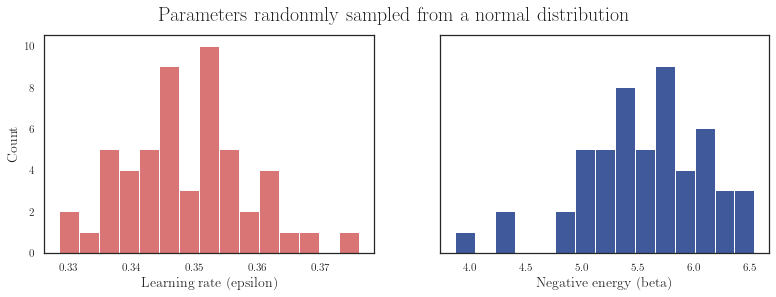

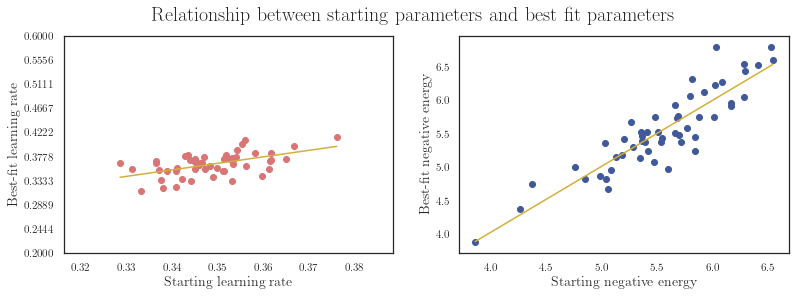

In [105]:
Behaviour.parameter_recovery(50, plot=True, save=('2.5.0', '2.5.1'))

Model 1


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Mean Epsilon: 0.37275081291069906
Std of Epsilon: 0.11901251898915283
Mean Rho: 5.879874621484116
Std of Rho: 1.170170944047196

Pearson correlations
  - Overall: (-0.21368528679185728, 0.14040861373650604)
  - MDD: (-0.3257507007660816, 0.18711839639553804)
  - Healthy: (-0.13067547251215372, 0.48349973555807363)

T-test
Epsilon
  - T statistic: 1.326168737150209
  - p value: 0.19119266544718536
Rho
  - T statistic: 0.3083684058904253
  - p value: 0.7591646567846637

Model 2


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:169: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:169: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:169: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: invali

Mean Epsilon: 0.3509244926771274
Std of Epsilon: 0.12185692240099885
Mean Beta: 6.042842649280355
Std of Beta: 1.3374159562343235

Pearson correlations
  - Overall: (-0.25691336098158324, 0.06877045592226895)
  - MDD: (-0.34445671855071813, 0.16158350386504197)
  - Healthy: (-0.13422392265871896, 0.45644899875522044)

T-test
Epsilon
  - T statistic: 1.513370123409767
  - p value: 0.1366095493772846
Beta
  - T statistic: -0.5130776263337231
  - p value: 0.6102025993331982


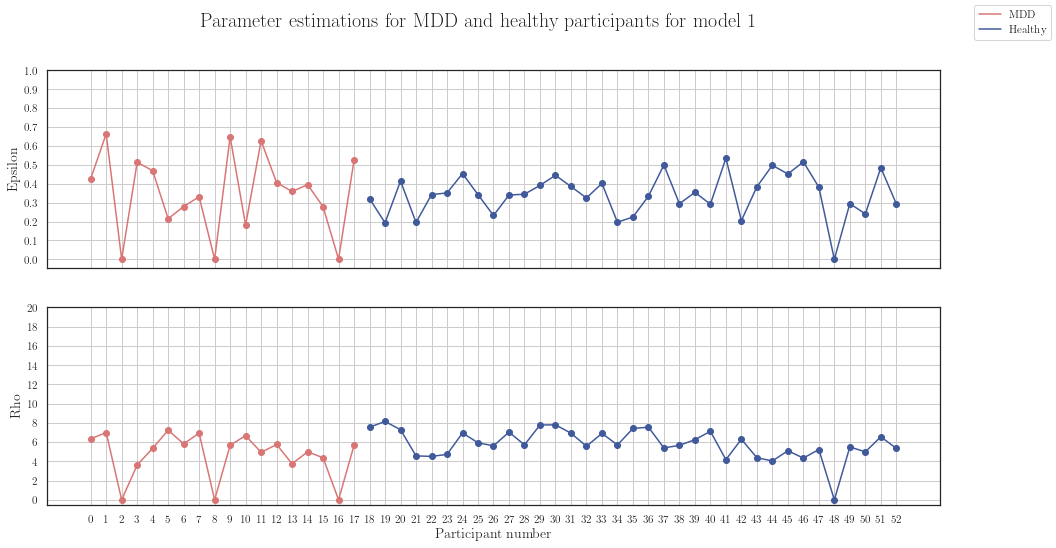

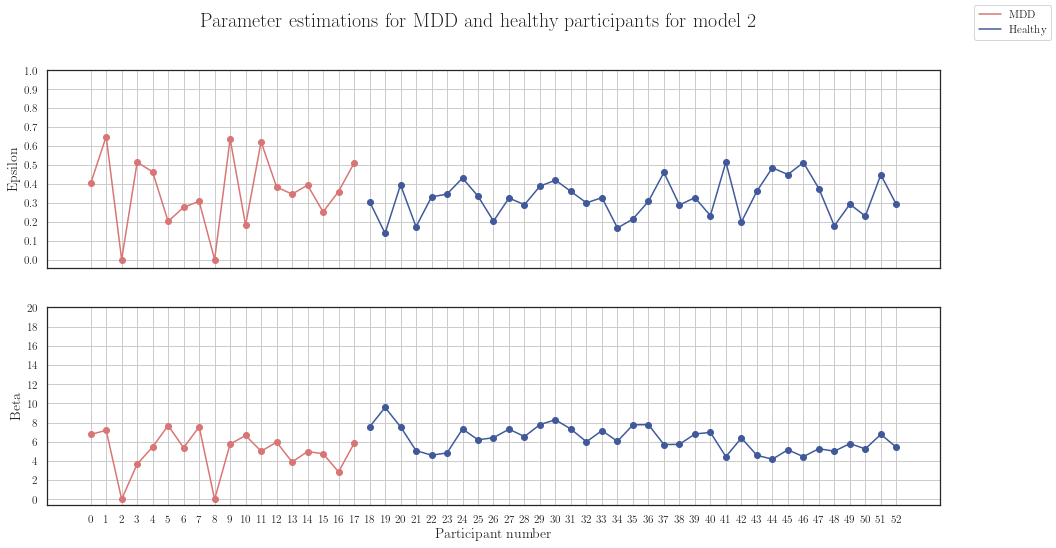

In [5]:
print('Model 1')
real_data_m1 = RealData(model=1)
#
real_data_m1.model_fit_stats(filter_params=True, title='for model 1', save='2.6.1')

print('\nModel 2')
real_data_m2 = RealData(model=2)
real_data_m2.model_fit_stats(filter_params=True, title='for model 2', save='2.6.2')

In [150]:
DECISION_INPUTS = namedtuple('Inputs', 'v, a, s, z, dt, timesteps, reps', 
                             defaults=(0.03, 0.12, 0.04, None, 0.001, 2000, 100))


class Decision(object):
     
    plot_params = {
        'label_size': 14,
        'title_size': 20,
        'subplot_size': 16,
        'blue': '#40599B',
        'red': '#D97575',
        'gold': '#d4af37',
    } 
    
    def __init__(self, params, bias=0):
        np.random.seed(1234)

        self.params = params._replace(z = bias * (params.a / 2.0) + (params.a / 2.0))
        (self.simulations, self.decisions, 
         self.h_plus_times, self.h_min_times) = self.simulate()
        self.times = np.linspace(0, self.params.dt * self.params.timesteps, 
                                      num=self.params.timesteps)
        self.time_ticks = np.linspace(0, self.params.dt * self.params.timesteps, 
                                      num=int(self.params.timesteps / 100) + 1)
            

    def simulate(self):
        simulations, decisions = [], []
        h_plus_times, h_min_times = [], []
        for _ in range(self.params.reps):
            W = self.params.z
            Ws = []
            decided = False
            for t in range(self.params.timesteps):
                
                noise = np.random.normal(0, np.sqrt(self.params.dt))
                if W > self.params.a:
                    if not decided:
                        h_plus_times.append(t)
                        decided = True
                elif W < 0:
                    if not decided:
                        h_min_times.append(t)
                        decided = True
                else:
                    W = W + self.params.v * self.params.dt + self.params.s * noise
                Ws.append(W)
            
            simulations.append(Ws)
            if W > self.params.a:
                decisions.append(1)
            elif W < 0:
                decisions.append(-1)
            else:
                decisions.append(0)
        return simulations, decisions, h_plus_times, h_min_times
    
    def plot(self):
        self.plot_example_paths()
        self.plot_distributions()
    
    def plot_example_paths(self, n=10):
        fig = plt.figure(figsize=(20,5))
        choices = np.random.choice(range(len(self.simulations)), n, replace=False)
    
        plt.plot(self.times, [self.params.a] * len(self.times), 
                 color=Decision.plot_params['blue'], linestyle='--', 
                 label='$h_+$ threshold')
        plt.plot(self.times, 0 * self.times,  
                 color=Decision.plot_params['red'], linestyle='--', 
                 label='$h_-$ threshold')
        
        for i in choices:
            plt.plot(self.times, self.simulations[i])

        plt.xlabel('Time (s)', fontsize=Decision.plot_params['label_size'])
        plt.ylabel('W', fontsize=Decision.plot_params['label_size'])
        plt.title(f'{n} random examples of a Wiener drift decision process', 
                  fontsize=Decision.plot_params['title_size'])   
        plt.legend(prop={'size': Decision.plot_params['subplot_size']})
        
    def plot_distributions(self):
        fig, axs = plt.subplots(1, 3, figsize=(20,4))
        num_plus = len(self.h_plus_times)
        num_min = len(self.h_min_times)
        num_none = self.params.reps - (num_plus + num_min)
        print(f'Number of h+: {num_plus}; {round(num_plus / self.params.reps * 100, 2)}%')
        print(f'Number of undecided: {num_none}; {round(num_none / self.params.reps * 100, 2)}%')
        print(f'Number of h-: {num_min}; {round(num_min / self.params.reps * 100, 2)}%')
        
        axs[0].bar(['$h_-$', 'undecided', '$h_+$'], [num_min, num_none, num_plus], 
                   color=Decision.plot_params['gold'])
        axs[0].set_title('Distribution of decisions', 
                         fontsize=Decision.plot_params['subplot_size'])
        axs[1].hist(self.h_plus_times, color=Decision.plot_params['blue'], bins=10)
        axs[1].set_title('Distribution of times to decide $h_+$.', 
                         fontsize=Decision.plot_params['subplot_size'])
        axs[2].hist(self.h_min_times, color=Decision.plot_params['red'], bins=10)
        axs[2].set_title('Distribution of times to decide $h_-$.', 
                         fontsize=Decision.plot_params['subplot_size'])

    @staticmethod    
    def explore_parameters(inputs):
        for i in inputs:
            params = DECISION_INPUTS(v=i[0], a=i[1])
            dd = Decision(params)
            print(f'\nInputs: v = {i[0]}, a = {i[1]}')
            dd.plot()
    
   
        
        

Number of h+: 64; 64.0%
Number of undecided: 26; 26.0%
Number of h-: 10; 10.0%


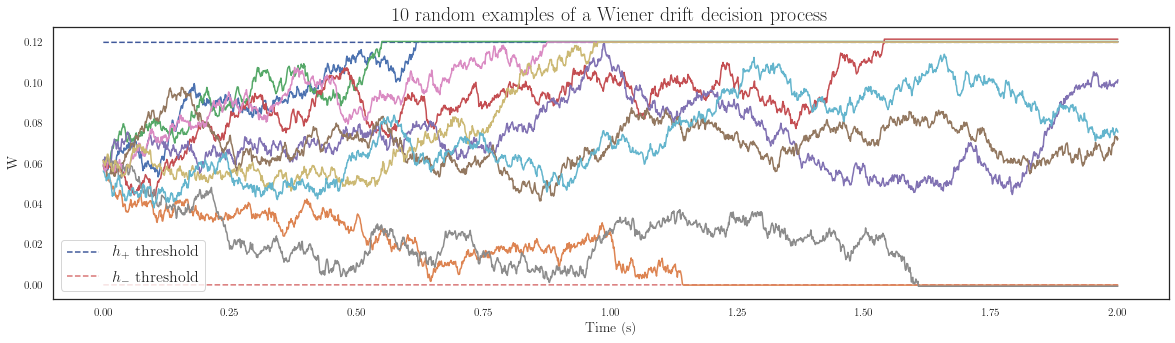

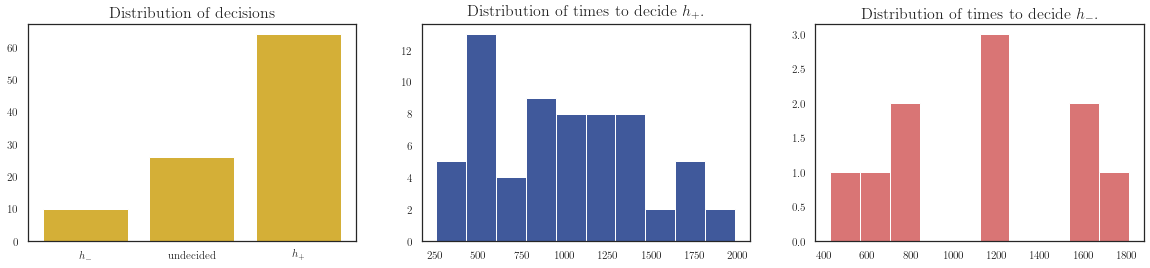

In [39]:
dd = Decision(DECISION_INPUTS())
dd.plot()



Inputs: v = 0.03, a = 0.12
Number of h+: 64; 64.0%
Number of undecided: 26; 26.0%
Number of h-: 10; 10.0%

Inputs: v = 0.06, a = 0.12
Number of h+: 91; 91.0%
Number of undecided: 9; 9.0%
Number of h-: 0; 0.0%

Inputs: v = 0.03, a = 0.06
Number of h+: 80; 80.0%
Number of undecided: 0; 0.0%
Number of h-: 20; 20.0%

Inputs: v = 0.06, a = 0.06
Number of h+: 90; 90.0%
Number of undecided: 1; 1.0%
Number of h-: 9; 9.0%

Inputs: v = 0, a = 0.06
Number of h+: 56; 56.0%
Number of undecided: 3; 3.0%
Number of h-: 41; 41.0%


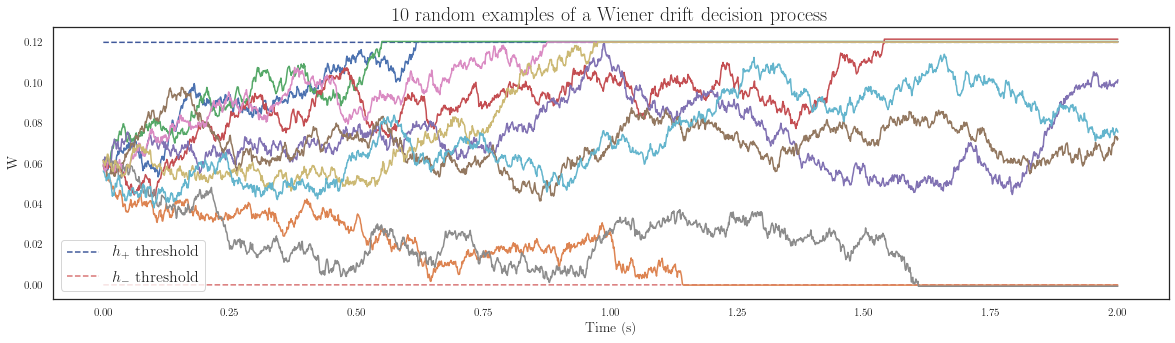

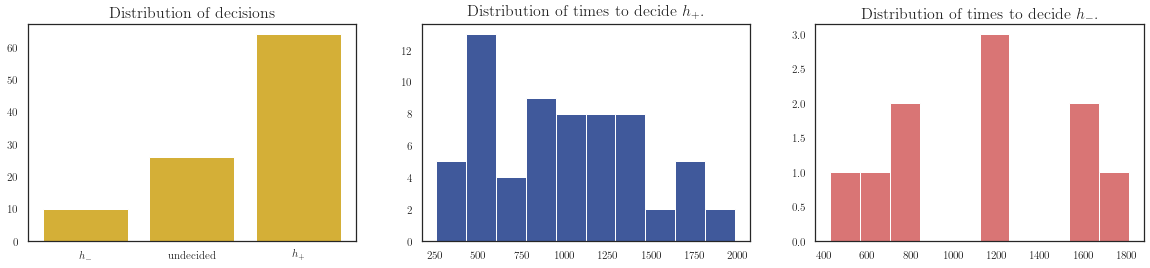

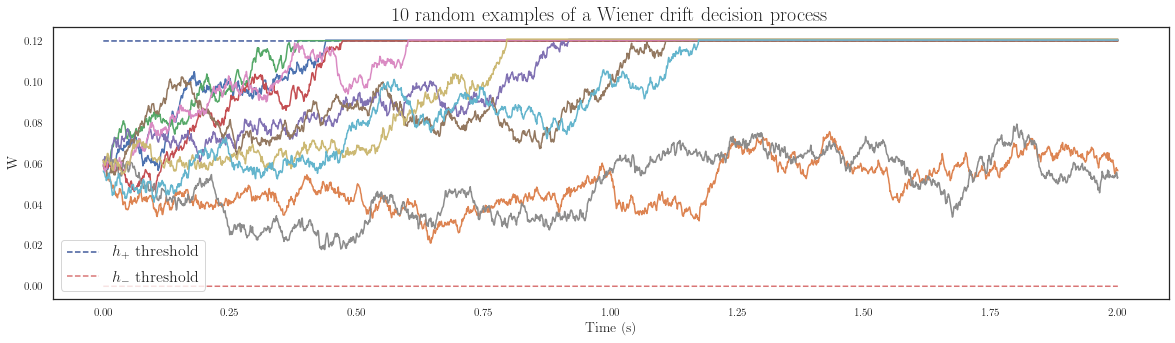

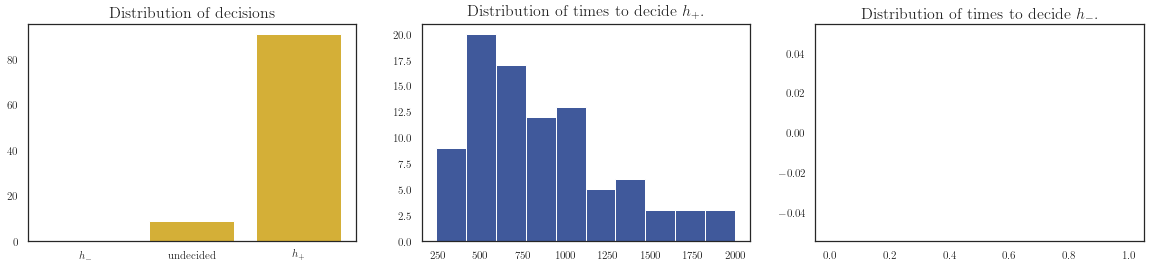

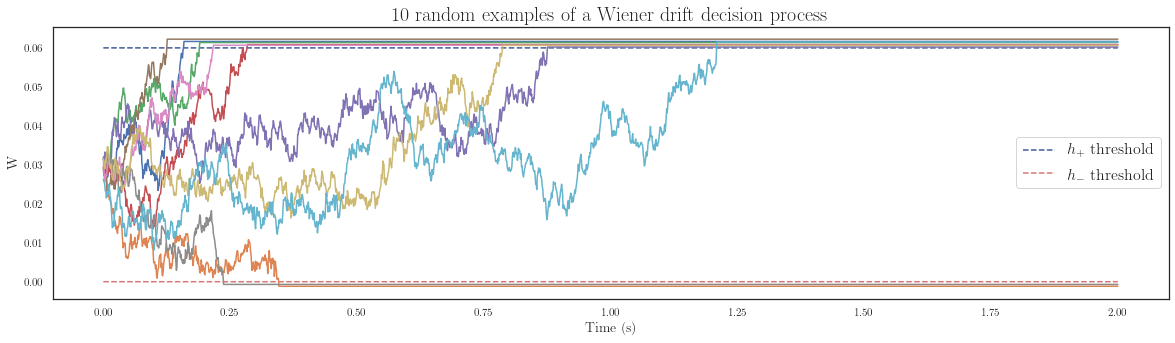

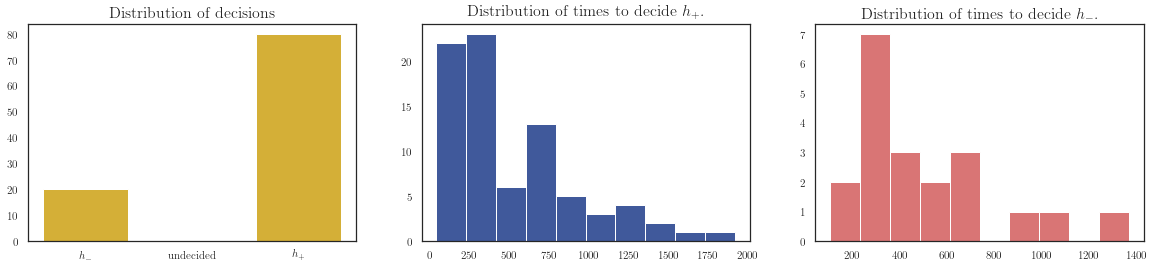

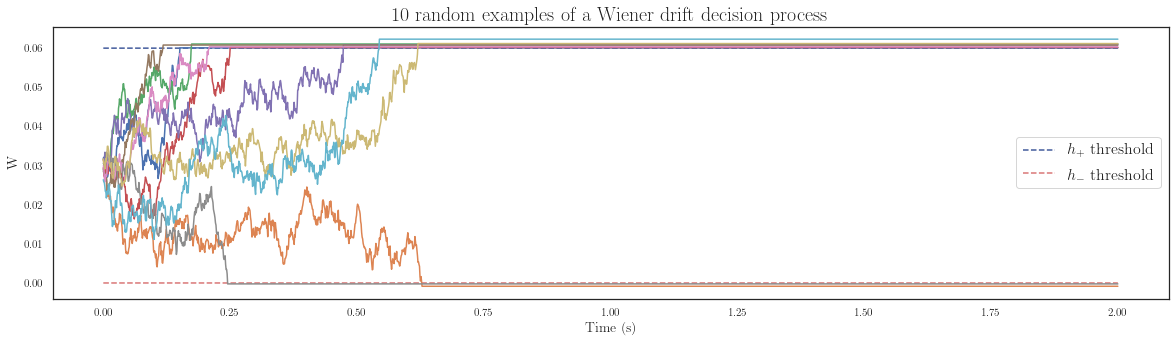

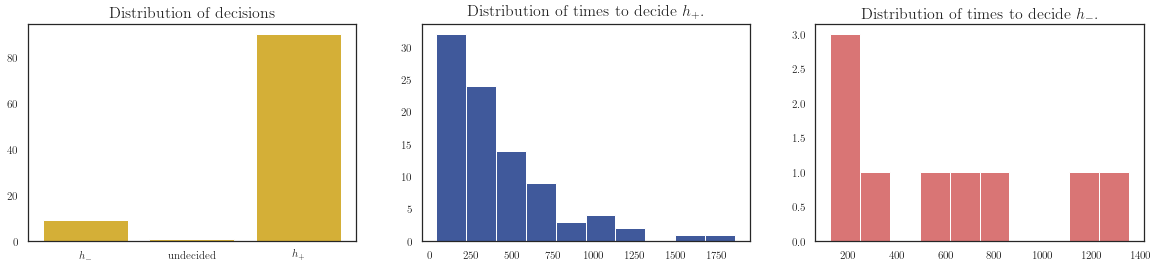

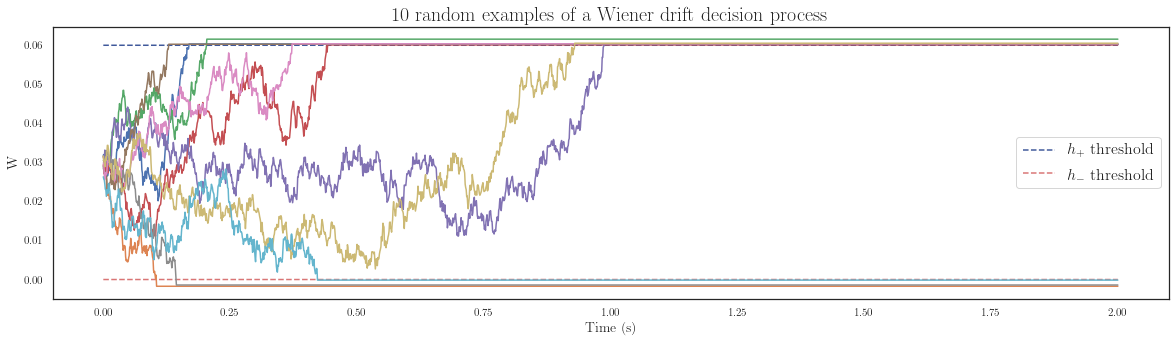

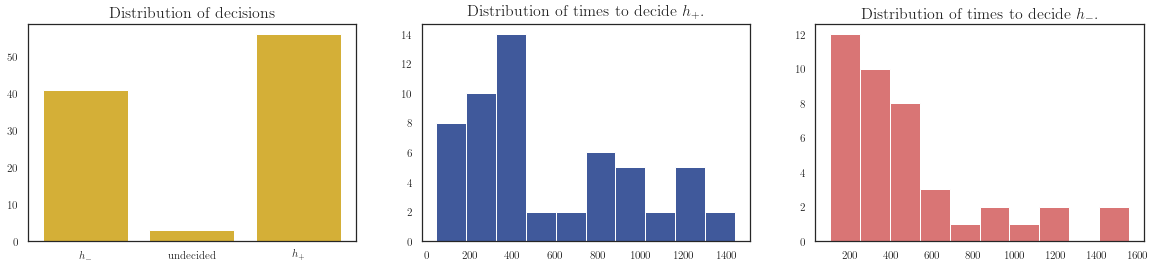

In [40]:
Decision.explore_parameters([(0.03, 0.12), (0.06, 0.12), (0.03, 0.06), (0.06, 0.06), (0, 0.06)])

Number of h+: 41; 41.0%
Number of undecided: 39; 39.0%
Number of h-: 20; 20.0%


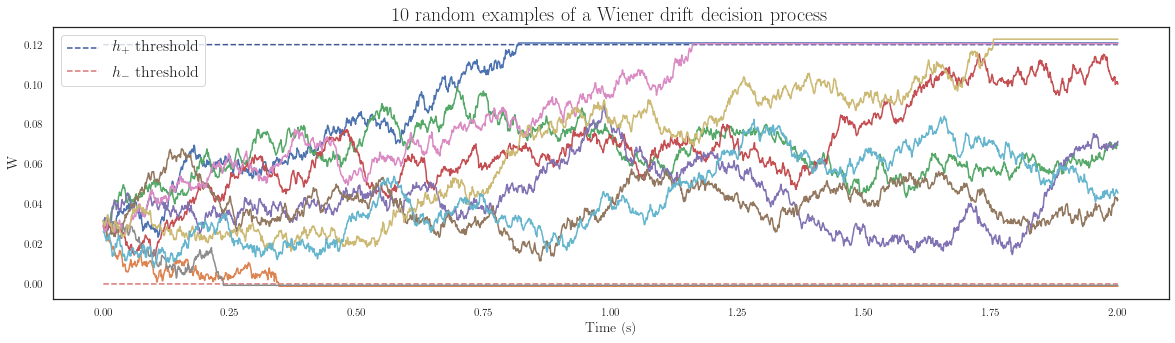

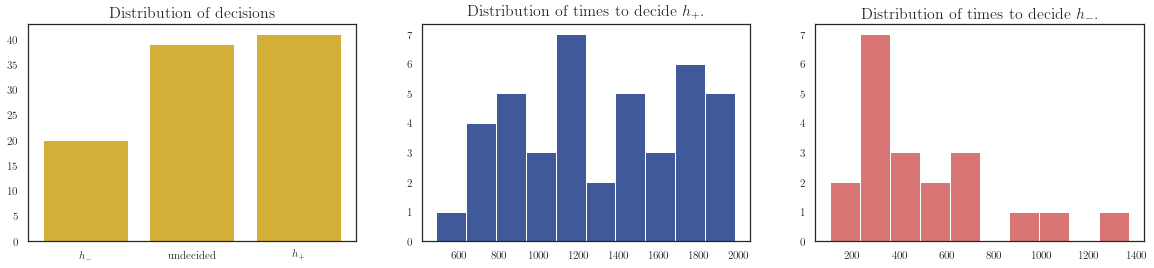

In [42]:
dd = Decision(DECISION_INPUTS(), bias=-0.5)
dd.plot()